In [1]:
import matplotlib.pyplot as plt
from matplotlib.container import BarContainer
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict
from os import listdir
import json

from utils.plotting import *

sns.set(style="ticks", font_scale=1.5, font="Liberation Sans")

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-a7gekuxh because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Read data

In [2]:
def read_data(folder):
    # Initialize list of dataframes that we will concatenate.
    all_data = []
    
    # Get list of all JSON results files in the folder.
    files_to_read = [f for f in listdir(folder) if f.endswith(".json")]

    # Read each file into a single dataframe.
    for f in files_to_read:
        with open(folder + "/" + f, "r") as fp:
            data = json.load(fp)
        results = pd.DataFrame(data["results"])
        for k, v in data["meta"].items():
            if not isinstance(v, list):
                results[k] = v
        results["corpus"] = f.split("_")[0]
        all_data.append(results)
    df = pd.concat(all_data)
    
    # Rename variables for better-looking figures.
    df["model"] = df.model.apply(pretty_model)
    df["eval_type"] = df.eval_type.apply(pretty_evaltype)
    return df

# Read results for all tasks.
RESULT_DIR = "./results_zh"
TASKS = [
    "exp1_word-prediction",
    # "exp2_word-comparison",
    "exp3a_sentence-judgment",
    "exp3b_sentence-comparison"
]
RESULTS = {
    task.split("_")[0]: read_data(f"{RESULT_DIR}/{task}")
    for task in TASKS
}

# Copy direct data from Experiment 3a to 3b.
_3a = RESULTS["exp3a"].copy()
_3a_direct = _3a[_3a.eval_type=="Direct"]
_3b = RESULTS["exp3b"].copy()
_3b = pd.concat([_3a_direct, _3b])
RESULTS["exp3b"] = _3b

# Figure 2: Task performance (also appendix Figures 4 & 5)

In [3]:
def compute_accuracy_metric(df, task):
    if task == "exp1":
        pass
    
    elif task == "exp2":
        df["model_prefers_good_continuation"] = \
            (df["logprob_of_good_continuation"] > df["logprob_of_bad_continuation"])
    
    elif task == "exp3b":
        def _success_criterion_sentence(row):
            if row.eval_type == "Direct":
                return (row.logprob_of_good_sentence > row.logprob_of_bad_sentence)
            else:
                return (row.logprob_of_good_continuation > row.logprob_of_bad_continuation)
        df["model_prefers_good_sentence"] = df.apply(_success_criterion_sentence, axis=1)
    
    else:
        # Accuracy for "direct"
        df["model_prefers_good_sentence"] = df.apply(
            lambda row: row.logprob_of_good_sentence > row.logprob_of_bad_sentence if row.eval_type == "Direct" else None,
            axis=1
        )
        # True positive
        df["model_prefers_yes_good"] = df.apply(
            lambda row: row.logprob_of_yes_good_sentence > row.logprob_of_no_good_sentence if row.eval_type != "Direct" else None,
            axis=1
        )
        # True negative
        df["model_prefers_no_bad"] = df.apply(
            lambda row: row.logprob_of_no_bad_sentence > row.logprob_of_yes_bad_sentence if row.eval_type != "Direct" else None,
            axis=1
        )
        # False positive
        df["model_prefers_yes_bad"] = df.apply(
            lambda row: row.logprob_of_yes_bad_sentence > row.logprob_of_no_bad_sentence if row.eval_type != "Direct" else None,
            axis=1
        )
        # False negative
        df["model_prefers_no_good"] = df.apply(
            lambda row: row.logprob_of_no_good_sentence > row.logprob_of_yes_good_sentence if row.eval_type != "Direct" else None,
            axis=1
        )
    return df

for task, df in RESULTS.items():
    RESULTS[task] = compute_accuracy_metric(df, task)

## Experiment 1: Word prediction

model             eval_type          
text-davinci-003  MetaQuestionComplex   -5.521090
                  MetaQuestionSimple    -3.671287
                  MetaInstruct          -3.553944
                  Direct                -3.346442
Name: logprob_of_gold_continuation, dtype: float64
Rendered figure to zh_exp1_task_performance.pdf


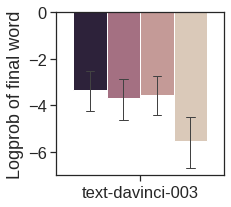

In [34]:
_df = RESULTS["exp1"]
metric = "logprob_of_gold_continuation"
metric_label = "Logprob of final word"
kwargs = dict(
    x="model",
    hue="eval_type",
    xlabel="",
    hue_order=[e for e in EVAL_TYPES if e in _df.eval_type.unique()],
    palette=EVAL_TYPE_PAL,
    legend_pos="outside",
    verbose=True
)

########################################
# Average over datasets
########################################

ax = plot_metric(_df[_df.model=="text-davinci-003"], metric, ylabel=metric_label, **kwargs)
ax.get_legend().remove()
plt.gcf().set_size_inches(3,3)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=0, ha="center")
render("zh_exp1_task_performance.pdf")

plt.show()

## Experiment 3b: Sentence comparison

NOTE: It's simpler to generate the plots for Experiment 3b than the plots for Experiment 3a, so we'll do it first.

In [6]:
_df = RESULTS["exp3b"]
metric = "model_prefers_good_sentence"
_df[_df.eval_type=="Direct"].groupby("model")[metric].mean()
# print(_df[_df.eval_type=="Direct"].logprob_of_good_sentence.mean())
# print(_df[_df.eval_type=="Direct"].logprob_of_bad_sentence.mean())
# _df[_df.eval_type=="Direct"].sort_values(by="logprob_of_bad_sentence")

model
text-davinci-003    0.611215
Name: model_prefers_good_sentence, dtype: float64

model             eval_type          
text-davinci-003  Direct                 0.611215
                  MetaQuestionComplex    0.777570
                  MetaQuestionSimple     0.787850
                  MetaInstruct           0.823364
Name: model_prefers_good_sentence, dtype: float64
Rendered figure to zh_exp3b_task_performance.pdf


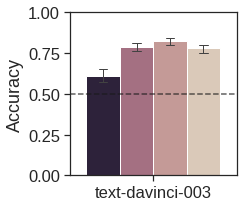

In [33]:
_df = RESULTS["exp3b"]
metric = "model_prefers_good_sentence"
metric_label = "Accuracy"
kwargs = dict(
    x="model",
    hue="eval_type",
    xlabel="",
    hue_order=[e for e in EVAL_TYPES if e in _df.eval_type.unique()],
    chance=0.5,
    ylim=(0,1),
    legend_pos="outside",
    verbose=True
)

########################################
# Average over datasets
########################################

ax = plot_metric(_df, metric, ylabel=metric_label, **kwargs)
ax.get_legend().remove()
plt.gcf().set_size_inches(3,3)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=0, ha="center")
render("zh_exp3b_task_performance.pdf")

plt.show()

## Experiment 3a: Sentence judgment

In [9]:
# Balanced accuracy: (TPR+TNR)/2
def balanced_accuracy(rows):
    tp = rows.model_prefers_yes_good.mean()
    tn = rows.model_prefers_no_bad.mean()
    return np.mean([tp, tn])

# Helper function for getting bootstrapped confidence intervals
# NOTE: this function was adapted from the scipy implementation
def bootstrap_ci(rows, fn, n_resamples=1000, confidence_level=0.95):
    stat_dist = []
    
    # Resample the data: random sample of the original sample (with replacement) of the same size as the original sample.
    for _ in range(n_resamples):
        sample = rows.sample(frac=1, replace=True)

    # Compute the bootstrap distribution of the statistic: for each set of resamples, compute the test statistic.
        test_stat = balanced_accuracy(sample)
        stat_dist.append(test_stat)

    # Determine the confidence interval.

    # Calculate percentile interval
    alpha = (1 - confidence_level)/2
    interval = alpha, 1-alpha

    def percentile_fun(a, q):
        return np.percentile(a=a, q=q, axis=-1)

    # Calculate confidence interval of statistic
    ci_l = percentile_fun(stat_dist, interval[0]*100)
    ci_u = percentile_fun(stat_dist, interval[1]*100)
    return ci_l, ci_u

# Wrapper function for getting CIs
def balanced_accuracy_ci(df):
    res = []
    for model in df.model.unique():
        for eval_type in META_EVAL_TYPES:
            # Get relevant rows.
            rows = df[(df.model==model)&(df.eval_type==eval_type)]

            # Bootstrap 95% CI.
            print(f"Bootstrapping CI for {model}, {eval_type}...")
            ci_l, ci_u = bootstrap_ci(rows, balanced_accuracy)

            # Compute accuracy.
            res.append(dict(
                model=model,
                eval_type=eval_type,
                accuracy=balanced_accuracy(rows),
                ci_low=ci_l,
                ci_high=ci_u
            ))
    acc = pd.DataFrame(res)
            
    return acc

# Compute accuracy and CIs
def get_accuracy_data_3a(df):
    # Get accuracy and CIs for metalinguistic methods.
    acc = balanced_accuracy_ci(df)
    
    # Compute accuracy for direct condition.
    direct_acc = []
    for corpus in df.corpus.unique():
        for model in acc.model.unique():
            rows = df[(df.model==model)&(df.eval_type=="Direct")&(df.corpus==corpus)]
            for item_id in rows.item_id.unique():
                direct_acc.append(dict(
                    model=model,
                    eval_type="Direct",
                    corpus=corpus,
                    accuracy=int(rows[rows.item_id==item_id].squeeze().model_prefers_good_sentence)
                ))
    direct_acc = pd.DataFrame(direct_acc)
    full_acc = pd.concat([direct_acc, acc])
    return full_acc

In [10]:
_df = RESULTS["exp3a"]
_acc = get_accuracy_data_3a(_df)

Bootstrapping CI for text-davinci-003, MetaQuestionSimple...
Bootstrapping CI for text-davinci-003, MetaInstruct...
Bootstrapping CI for text-davinci-003, MetaQuestionComplex...
Bootstrapping CI for text-davinci-003, MetaQuestionComplexOptionFirst...
Bootstrapping CI for text-davinci-003, MetaInstructKeywords...


Direct
MetaQuestionSimple
MetaInstruct
MetaQuestionComplex
Rendered figure to zh_exp3a_task_performance.pdf


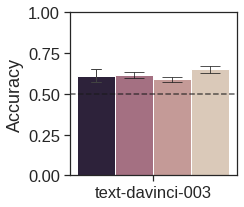

In [32]:
metric = "accuracy"
metric_label = "Accuracy"
kwargs = dict(
    x="model",
    # order=[e for e in EVAL_TYPES if e in _df.eval_type.unique()],
    hue="eval_type",
    xlabel="",
    hue_order=[e for e in EVAL_TYPES if e in _df.eval_type.unique()],
    chance=0.5,
    ylim=(0,1),
    legend_pos="outside"
)

def add_metalinguistic_errorbars(ax, acc_df):
    eval_types = [e for e in EVAL_TYPES if e in acc_df.eval_type.unique()]
    model_order = [m for m in GLOBAL_MODEL_ORDER if m in acc_df.model.unique()]
    # Add custom error bars for metalinguistic conditions
    for eval_type_idx, container in enumerate(ax.containers):
        if isinstance(container, BarContainer):
            eval_type = eval_types[eval_type_idx]
            print(eval_type)

            # We don't need to manually add error bars for Direct method.
            if eval_type != "Direct":
                for model_idx, bar in enumerate(container.get_children()):
                    model = model_order[model_idx]
                    row = acc_df[(acc_df.eval_type==eval_type)&(acc_df.model==model)].squeeze()
                    ci_l = row.ci_low
                    ci_u = row.ci_high
                    ax.errorbar(
                        bar.get_x()+bar.get_width()/2, 
                        bar.get_height(), 
                        yerr=(ci_u - bar.get_height()), 
                        capsize=10, elinewidth=1,
                        color="k",
                        alpha=0.75
                    )
    # manually adjust x-axis limits, which get shifted by errorbar plotting
    # ax.set_xlim(-0.5, 5.5)
    return ax

########################################
# Average over datasets
########################################

ax = plot_metric(_acc, metric, ylabel=metric_label, **kwargs)
ax.get_legend().remove()
ax = add_metalinguistic_errorbars(ax, _acc)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=0, ha="center")
plt.gcf().set_size_inches(3,3)
render("zh_exp3a_task_performance.pdf")
plt.show()